In [1]:
import pandas as pd
import os
import json
import pytz
# Plotting imports
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm

In [2]:
def labeler_uniques(df: pd.DataFrame, column_name: str) -> dict:
    # Get unique values in the specified column
    unique_values = df[column_name].unique()
    
    # Create a dictionary mapping each unique value to a unique number
    unique_dict = {value: i for i, value in enumerate(unique_values)}
    
    return unique_dict
    
def add_mapped_column(df: pd.DataFrame, column_name: str, new_column_name: str) -> pd.DataFrame:
    # Get unique values and create a dictionary mapping each unique value to a unique number
    unique_dict = labeler_uniques(df, column_name)
    
    # Use the map function to create a new column with the mapped values
    df[new_column_name] = df[column_name].map(unique_dict)
    
    return df

In [3]:
def retrieve_data(data_path = "../data1/", start_idx=0, stop_idx=60):
    # list to store files
    f_store = []
    results = {}
    columns = []
    
    # Iterate directory
    for file_name in os.listdir(data_path):
        # check if current file_path is a file
        if os.path.isfile(os.path.join(data_path, file_name)):
            # add filename to list
            f_store.append(file_name)

    flag = True
    for file_name in f_store:
        data = {}
        tmp_dt = ''
        # Open the JSON file
        with open(data_path + file_name) as file:
            data = json.load(file)
        for i in range(start_idx, stop_idx+1):
            try:
                if data:
                    if i == start_idx:
                        tmp_dt = data[str(i)]['timestamp']
                    
                    if file_name == f_store[0]:
                        columns.append(data[str(i)]['name'])
                    if flag:
                        if i == start_idx:
                            results['timestamp'] = [tmp_dt]
                        results[columns[i]] = [data[str(i)]['value']]
                    else:
                        if i == start_idx:
                            results['timestamp'].append(tmp_dt)
                        results[columns[i]].append(data[str(i)]['value'])
            except KeyError:
                print(file_name)
                print(i)
                pass
        flag = False
    #print(results)
    return results

In [4]:
def annotation_plot(df, fields, names, units, annotations):
    # Create a figure with subplots
    num_fields = len(fields)
    fig, axes = plt.subplots(num_fields, 1, figsize=(15, 5 * num_fields))
    fig.subplots_adjust(hspace=0.5)  # Adjust space between subplots

    # Create timezone for x-axis formatting
    est = pytz.timezone('US/Eastern')
    myFmt = mdates.DateFormatter('%H:%M', tz=est)

    # Get unique labels from the annotations and assign colors to them
    unique_labels = annotations.iloc[:, -1].unique()  # Last column is the numeric label
    colors = plt.get_cmap('tab10', len(unique_labels))  # Generate different colors

    # Create a mapping between labels and colors
    label_to_color = {label: colors(i) for i, label in enumerate(unique_labels)}

    # Iterate through the fields and create individual plots
    for idx in range(num_fields):
        temp = df[[fields[idx]]]
        axes[idx].plot(df['EST'], temp, label=names[idx])
        
        # Set x-axis formatter and labels
        axes[idx].xaxis.set_major_formatter(myFmt)
        axes[idx].set_xlabel('Time (HH:MM)')
        axes[idx].set_ylabel(f'{names[idx]} ({units[idx]})')  # Use unit from the units list
        axes[idx].set_title(f'{names[idx]} Over Time')

        c = []
        # Add vertical lines for each annotation
        for i, row in annotations.iterrows():
            timestamp = row['Time_UTC']  # Assuming the timestamp is in the first column
            label = row['Label']  # Assuming the label is in the last column
            color = label_to_color[label]
            name = row['Identifier']
            
             # Plot vertical line, only assign label to the first occurrence of the label
            if color not in c:
                axes[idx].axvline(pd.to_datetime(timestamp), color=color, linestyle='--', label=f'Label {name}')
                c.append(color)
            else:
                axes[idx].axvline(pd.to_datetime(timestamp), color=color, linestyle='--', label='_nolegend_')

    # Add a legend to each subplot
    for ax in axes:
        ax.legend()

    plt.show()

In [5]:
df_working = pd.read_csv('MMRI_annotations 22-08-2024.csv', skiprows=1)
#df_working['Time']= pd.to_datetime(df_working['Time'],  format='%H:%M:%S')
# Assuming df_working['Time'] has time in HH:MM:SS format
df_working['Time'] = pd.to_datetime('2024-08-22 ' + df_working['Time'].astype(str), format='%Y-%m-%d %H:%M:%S')


# Add 5 hours to the 'Time' column
df_working['Time'] = df_working['Time'] + pd.Timedelta(hours=3, minutes=32, seconds=31)

# Localize to EDT (Eastern Daylight Time)
eastern = pytz.timezone('EST')
df_working['Time_EDT'] = df_working['Time'].dt.tz_localize(eastern)

# Convert to UTC
df_working['Time_UTC'] = df_working['Time_EDT'].dt.tz_convert('UTC')
df_working.head(18)

,Time,Human,Event,Identifier,Time_EDT,Time_UTC
0,2024-08-22 18:03:51,YL,Material start to get out of nozzle,System,2024-08-22 18:03:51-05:00,2024-08-22 23:03:51+00:00
1,2024-08-22 18:05:14,YL,Pump stop,System,2024-08-22 18:05:14-05:00,2024-08-22 23:05:14+00:00
2,2024-08-22 18:05:35,YL,Pump auto,System,2024-08-22 18:05:35-05:00,2024-08-22 23:05:35+00:00
3,2024-08-22 18:13:03,YL,Accelerator in printhead,System,2024-08-22 18:13:03-05:00,2024-08-22 23:13:03+00:00
4,2024-08-22 18:13:55,YL,Color change,Extrudate good,2024-08-22 18:13:55-05:00,2024-08-22 23:13:55+00:00
5,2024-08-22 18:14:24,YL,Accelerator pump down to 48,System,2024-08-22 18:14:24-05:00,2024-08-22 23:14:24+00:00
6,2024-08-22 18:16:22,YL,"First zigzag print (5%accelerator, 200)",Printing,2024-08-22 18:16:22-05:00,2024-08-22 23:16:22+00:00
7,2024-08-22 18:17:53,YL,Print finish,Printing,2024-08-22 18:17:53-05:00,2024-08-22 23:17:53+00:00
8,2024-08-22 18:18:18,YL,Mixing speed 300,System,2024-08-22 18:18:18-05:00,2024-08-22 23:18:18+00:00
9,2024-08-22 18:20:17,YL,Second zigzag line,Printing,2024-08-22 18:20:17-05:00,2024-08-22 23:20:17+00:00


In [6]:
add_mapped_column(df_working, 'Identifier', 'Label') 
#df_working.head(10)

,Time,Human,Event,Identifier,Time_EDT,Time_UTC,Label
0,2024-08-22 18:03:51,YL,Material start to get out of nozzle,System,2024-08-22 18:03:51-05:00,2024-08-22 23:03:51+00:00,0
1,2024-08-22 18:05:14,YL,Pump stop,System,2024-08-22 18:05:14-05:00,2024-08-22 23:05:14+00:00,0
2,2024-08-22 18:05:35,YL,Pump auto,System,2024-08-22 18:05:35-05:00,2024-08-22 23:05:35+00:00,0
3,2024-08-22 18:13:03,YL,Accelerator in printhead,System,2024-08-22 18:13:03-05:00,2024-08-22 23:13:03+00:00,0
4,2024-08-22 18:13:55,YL,Color change,Extrudate good,2024-08-22 18:13:55-05:00,2024-08-22 23:13:55+00:00,1
...,...,...,...,...,...,...,...
85,2024-08-22 18:57:24,AK,Under extrusion continues and looks worse,System,2024-08-22 18:57:24-05:00,2024-08-22 23:57:24+00:00,0
86,2024-08-22 18:57:50,AK,Add new accelerator,System,2024-08-22 18:57:50-05:00,2024-08-22 23:57:50+00:00,0
87,2024-08-22 18:57:58,AK,Filament is less red looks almost white,System,2024-08-22 18:57:58-05:00,2024-08-22 23:57:58+00:00,0
88,2024-08-22 18:58:23,AK,new filaments look like they are buckling,System,2024-08-22 18:58:23-05:00,2024-08-22 23:58:23+00:00,0


In [7]:
res=retrieve_data(data_path = "../data2/")
df = pd.DataFrame.from_dict(res)
df['timestamp']= pd.to_datetime(df['timestamp'],  format='%d.%m.%Y %H:%M:%S,%f')
df['EST'] = (df.timestamp.dt.tz_localize('UTC').dt.tz_convert('US/Eastern'))
#df.head()

In [8]:
fields = [
    'GECO/MP_Pump_Pressure_Current_bar_R',
    'GECO/MPTX_DI_Water_Temperature_C_R',
    'GECO/MPXMB_Pump_OutputCurrent_dA_I',
    'GECO/MPXMB_Pump_OutputPower_W_I',
    'GECO/MPTX_DI_Mortar_Temperature_C_R',
#    'GECO/MPTX_DI_Air_Temperature_C_R' 
]

names = [
    'Pump Pressure',
    'Water Temp',
    'Pump Current',
    'Pump Power',
    'Mortar Tempurature',
#    'Ambient Temp'
]

units = [
    'BAR',
    'C',
    'dA',
    'W',
    'C'
#    'C'
]

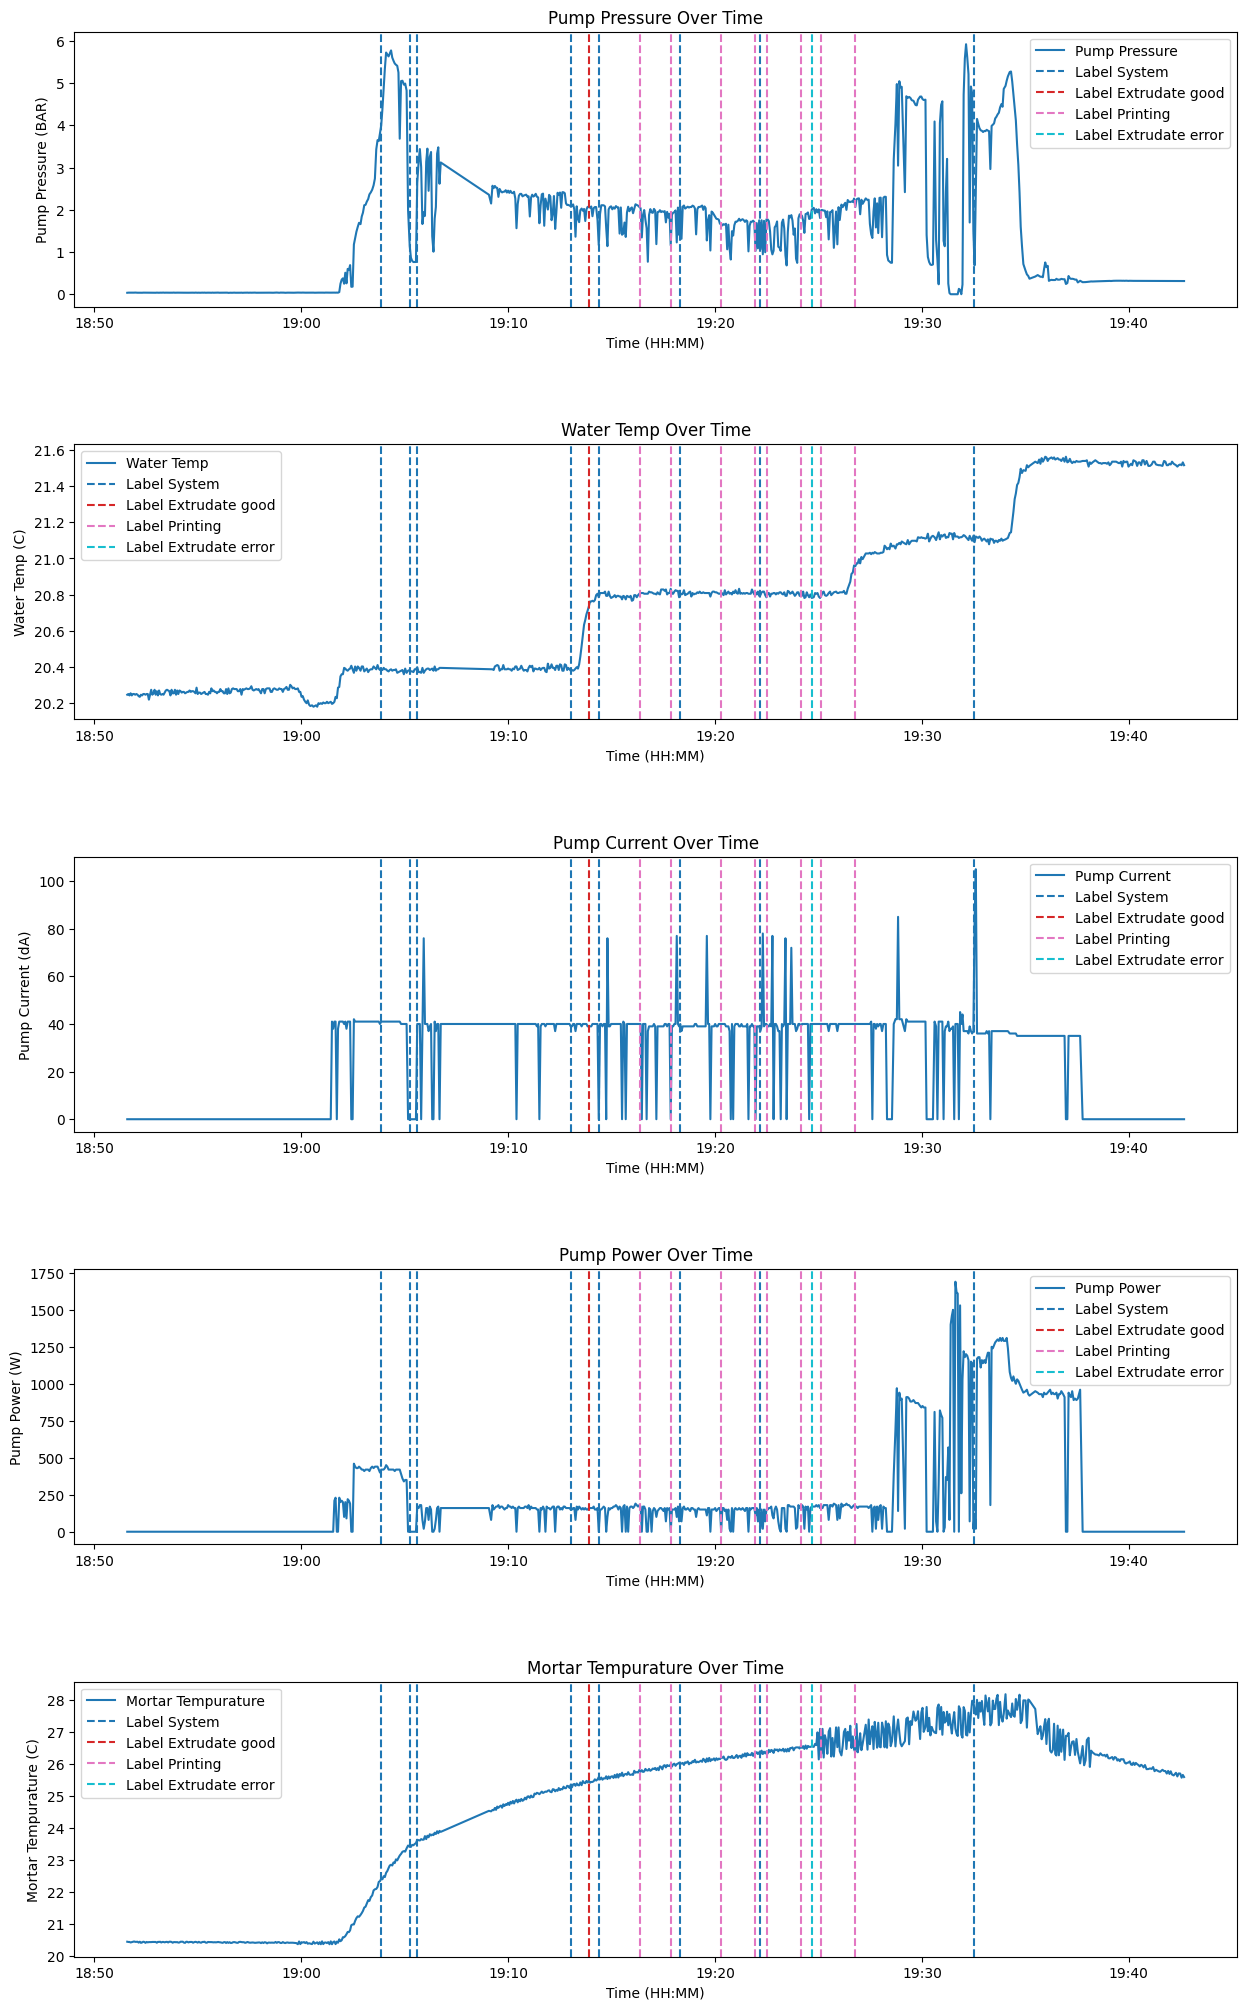

In [9]:
# Shit Material
annotation_plot(df[600:1400], fields, names, units, df_working[0:18])